In [227]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

In [228]:
# Load the CSV file into a DataFrame
df = pd.read_csv('EVChargingStationUsage.csv',low_memory=False)

In [229]:
df.isna().sum().sort_values(ascending=False)[df.isna().sum() > 0] # Check for missing values (We have a lot)

County                             84665
EVSE ID                            78948
System S/N                         78948
Model Number                       78948
Driver Postal Code                  8402
User ID                             7677
Currency                            1788
Ended By                             248
Transaction Date (Pacific Time)      209
Port Type                              9
dtype: int64

In [230]:
# US county:
# https://www.getzips.com/zip.htm -- determine the county of the zip code, however there is overlap in 94303, Thus: df[df['Postal Code']==94303]['Address 1'].unique()
# From https://geocoding.geo.census.gov/geocoder/geographies
# 3700 Middlefield Rd = Santa Clara
# 1213 Newell Rd = Santa Clara
# 1514 Walnut Dr = Santa Clara
# 1520 Walnut Dr = Santa Clara
# Therefore all of 94303 is in Santa Clara County so all the NaN values can be filled in with Santa Clara

In [231]:
# This cleans up the data a bit
df['Org Name'] = df['Org Name'].unique()[0] # There are multiple values in this column, but they are all the same with a space as the only difference
df['MAC Address'] = df['MAC Address'].str.replace(':', '') # Clean up the MAC Address
df['Station Name'] = df['Station Name'].str.replace('PALO ALTO CA / ', '').str.replace('#','').str.replace('  ',' ').str.replace(' ','_') # Clean up the Station Name
df['Total Duration (m)'] = pd.to_timedelta(df['Total Duration (hh:mm:ss)']).dt.total_seconds()/60 # Convert the time to minutes
df['Charging Time (m)'] = pd.to_timedelta(df['Charging Time (hh:mm:ss)']).dt.total_seconds()/60 # Convert the time to minutes
df.drop(columns=['Total Duration (hh:mm:ss)', 'Charging Time (hh:mm:ss)'], inplace=True) # Drop the old columns
df['Port Type'] = df['Port Type'].fillna("Level " + df['Port Number'].astype(str)) # Fill in the missing values in Port Type with the value in Port Number
df['Currency'] = df['Currency'].fillna('Unknown') # Fill in the missing values in Currency with Unknown (ASSUMPTIONS!)
df['USD'] = df['Currency'] == 'USD' # Create a boolean column for USD
df['Ended By'] = df['Ended By'].fillna('Unknown') # Fill in the missing values in Ended By with Unknown (ASSUMPTIONS!)
df['County'] = df['County'].fillna('Santa Clara County') # Fill in the missing values in County with Santa Clara County (Based on the zip and address)
df['Start Date'] = pd.to_datetime(df['Start Date']) # Convert the Start Date to a datetime object
df['End Date'] = pd.to_datetime(df['End Date'],errors='coerce') # Convert the End Date to a datetime object
df['Transaction Date (Pacific Time)'] = pd.to_datetime(df['Transaction Date (Pacific Time)'],errors='coerce').fillna(df['End Date']) # Convert the Transaction Date to a datetime object and fill in the missing values with the End Date (ASSUMPIONS!)

In [232]:
df['Transaction Time (h)'] = df['Transaction Date (Pacific Time)'].dt.hour
df['Day of Week'] = df['Transaction Date (Pacific Time)'].dt.dayofweek
df['Day of Month'] = df['Transaction Date (Pacific Time)'].dt.day
df['Start Date (h)'] = df['Start Date'].dt.hour
df['End Date (h)'] = df['End Date'].dt.hour

In [233]:
# Drop NA values for invalid Dates (ASSUMPTIONS!)
df.dropna(subset=['Start Date', 'End Date', 'Transaction Date (Pacific Time)'], inplace=True)

In [234]:
df.isna().sum().sort_values(ascending=False)[df.isna().sum() > 0] # Check for missing values (We have a lot)

System S/N            78948
EVSE ID               78948
Model Number          78948
Driver Postal Code     8400
User ID                7675
dtype: int64

In [235]:
# We Should consider if 1. these columns are useful, 2. if they are useful, fill them with a new value (unknown, etc)
df[df['Model Number'].isna()].isna().sum().sort_values(ascending=False)[df.isna().sum() > 0]

System S/N            78948
EVSE ID               78948
Model Number          78948
Driver Postal Code     3191
User ID                2599
dtype: int64

In [236]:
df.columns # Check the columns to see what we have to work with

Index(['Station Name', 'MAC Address', 'Org Name', 'Start Date',
       'Start Time Zone', 'End Date', 'End Time Zone',
       'Transaction Date (Pacific Time)', 'Energy (kWh)', 'GHG Savings (kg)',
       'Gasoline Savings (gallons)', 'Port Type', 'Port Number', 'Plug Type',
       'EVSE ID', 'Address 1', 'City', 'State/Province', 'Postal Code',
       'Country', 'Latitude', 'Longitude', 'Currency', 'Fee', 'Ended By',
       'Plug In Event Id', 'Driver Postal Code', 'User ID', 'County',
       'System S/N', 'Model Number', 'Total Duration (m)', 'Charging Time (m)',
       'USD', 'Transaction Time (h)', 'Day of Week', 'Day of Month',
       'Start Date (h)', 'End Date (h)'],
      dtype='object')

In [237]:
df.nunique().sort_values(ascending=False) # Check the amount of unique values in each column

Start Date                         244762
End Date                           244119
Transaction Date (Pacific Time)    241042
Energy (kWh)                       118061
Plug In Event Id                    36836
Total Duration (m)                  31024
Charging Time (m)                   22473
User ID                             21440
GHG Savings (kg)                    15535
Gasoline Savings (gallons)           6333
Fee                                  1817
Driver Postal Code                    984
System S/N                             81
MAC Address                            68
Longitude                              64
Latitude                               62
EVSE ID                                51
Station Name                           46
Day of Month                           31
Transaction Time (h)                   24
Start Date (h)                         24
End Date (h)                           24
Address 1                              20
Ended By                          

There are a lot of unique values in the categorical sense, so it might be prudent to figure out what values to work with. Here is an initial list of suggestions
* Energy (kWh)
* Port Type
* Plug Type
* Postal Code (to indicate spatial location)
* Currency (Perhaps binary conversion USD/Not USD)
* Total Duration (m)
* Charging Time (m)
* Hour of Day
* Day of Week
* ?Maybe driver zipcode (There are over 900 and they are categorical)?

Potential for interesting insights:
* Model Number
* Ended By
* Fee
* Driver Postal Code
* Month

In [285]:
df_working = df[['Transaction Time (h)', 'Port Type', 'Plug Type', 'Charging Time (m)', 'Energy (kWh)', 'Total Duration (m)', 'Day of Week', 'USD', 'Postal Code']] # Select the columns we want to work with

In [280]:
df_working = pd.get_dummies(df_working, columns=['Port Type', 'Plug Type', 'Postal Code', 'Day of Week']) # One hot encode the data

# Predictive Model

In [ ]:
# Train test split, 70% training, 30% testing
X_train, X_test = df_working[:int(len(df)*0.7)], df_working[int(len(df)*0.7):]
y_train, y_test = X_train.pop('Energy (kWh)'), X_test.pop('Energy (kWh)')

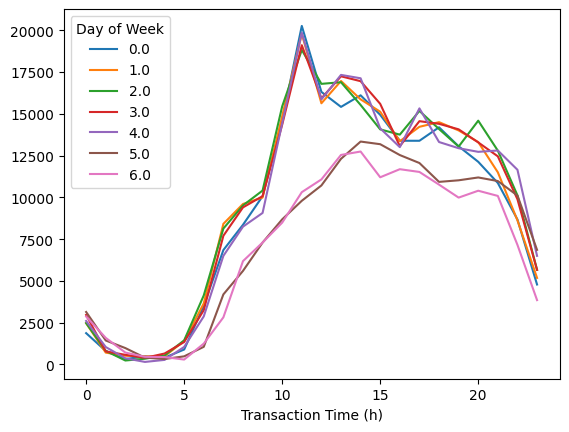

Baseline model score: nan


In [ ]:
# Baseline model: Historical average for each hour of the day and day of the week
y_pred = df_working[:int(len(df)*0.7)].groupby(['Transaction Time (h)', 'Day of Week'])['Energy (kWh)'].sum()
#df_working.groupby(['Transaction Time (h)', 'Day of Week'])['Energy (kWh)'].sum().unstack().plot(kind='bar', stacked=True)
y_pred.unstack().plot()
plt.show()

# Score the baseline model
y_pred = y_pred.reset_index()
y_pred = pd.merge(X_test, y_pred, on=['Transaction Time (h)', 'Day of Week'], how='left')['Energy (kWh)']
print('Baseline model score:', ((y_test - y_pred)**2).mean())

In [ ]:
# Linear Regression
lm = LinearRegression()
lm_scores = cross_val_score(lm, X_train, y_train, cv=20)
print("Linear Regression R^2: %0.4f (+/- %0.4f)" % (lm_scores.mean(), lm_scores.std() * 2))

# Ridge Regression
ridge = Ridge(alpha=0.5)
ridge_scores = cross_val_score(ridge, X_train, y_train, cv=20)
print("Ridge Regression R^2: %0.4f (+/- %0.4f)" % (ridge_scores.mean(), ridge_scores.std() * 2))

# Lasso Regression
lasso = Lasso(alpha=0.1)
lasso_scores = cross_val_score(lasso, X_train, y_train, cv=20)
print("Lasso Regression R^2: %0.4f (+/- %0.4f)" % (lasso_scores.mean(), lasso_scores.std() * 2))


Linear Regression R^2: 0.7581 (+/- 0.1430)
Ridge Regression R^2: 0.7581 (+/- 0.1430)
Lasso Regression R^2: 0.7424 (+/- 0.1671)


In [ ]:
# Determine the hyperparameter for Ridge and Lasso
from sklearn.model_selection import GridSearchCV

# Ridge
param_dist = {'alpha': [0.1, 0.5, 1, 5, 10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}
ridge_cv = GridSearchCV(ridge, param_dist, cv=10)
ridge_cv.fit(X_train, y_train)
print("Tuned Ridge Regression Parameters: {}".format(ridge_cv.best_params_))
print("Best score is {}".format(ridge_cv.best_score_))

# Lasso
param_dist = {'alpha': [0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]}
lasso_cv = GridSearchCV(lasso, param_dist, cv=10)
lasso_cv.fit(X_train, y_train)
print("Tuned Lasso Regression Parameters: {}".format(lasso_cv.best_params_))
print("Best score is {}".format(lasso_cv.best_score_))


Tuned Ridge Regression Parameters: {'alpha': 500}
Best score is 0.76000303317713
Tuned Lasso Regression Parameters: {'alpha': 0.1}
Best score is 0.7418381925531423


In [ ]:
# Using Ridge Regression with alpha=500
ridge = Ridge(alpha=500)
ridge.fit(X_train, y_train)
print("Ridge Regression R^2: %0.4f" % ridge.score(X_test, y_test))
print("Ridge Regression Coefficients: \n")
for i in range(len(ridge.coef_)):
    print(X_train.columns[i], ridge.coef_[i])

Ridge Regression R^2: 0.7979
Ridge Regression Coefficients: 

Transaction Time (h) 0.007207373604086241
Charging Time (m) 0.07393627266580044
Total Duration (m) -0.0014992413926400814
USD 0.8434852042629711
Port Type_Level 1 -1.9637160834953893
Port Type_Level 2 1.9637160834953804
Plug Type_J1772 1.9637160834953795
Plug Type_NEMA 5-20R -1.963716083495395
Postal Code_94301 0.09494572258084913
Postal Code_94303 0.6374505241359993
Postal Code_94306 -0.732396246716668
Day of Week_0.0 -0.12741181541522129
Day of Week_1.0 -0.18391895505544537
Day of Week_2.0 -0.21501014376175262
Day of Week_3.0 -0.18806983917307835
Day of Week_4.0 -0.10289276785863406
Day of Week_5.0 0.3449807392243603
Day of Week_6.0 0.4723227820398429
